In [1]:
import pandas as pd 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
trainCsv = pd.read_csv('train.csv')
trainCsv

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,Id
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,0
1,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,3
2,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,4
3,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,50.0,...,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1.0,6
4,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,30.0,...,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,Lee Mayberry,82,18.3,5.2,2.1,4.6,45.6,0.5,1.3,39.1,...,57.4,0.3,1.1,1.4,3.3,0.7,0.1,1.0,1.0,1331
939,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0,1335
940,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0,1336
941,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0,1338


In [3]:
trainDataset = trainCsv.to_numpy()
X, y = trainDataset[:, 1:-2], trainDataset[:, -2]
for col in range(X.shape[1]):
    X[:, col] /= X[:, col].max()

avgImputer = SimpleImputer()
X = avgImputer.fit_transform(X, y)


xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

testCsv = pd.read_csv('test.csv')
testDataset = testCsv.to_numpy()
ids, testDatasetX = testDataset[:, -1], testDataset[:, 1:-1]
testDatasetX = avgImputer.transform(testDatasetX)
testDatasetX = testDatasetX.astype(float)

for col in range(testDatasetX.shape[1]):
    testDatasetX[:, col] /= testDatasetX[:, col].max()

c:\Users\aarav\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


In [ ]:
class LogisticRegression:
    def __init__(self, X, y, decisionBoundary=0.5, momentumCoefficient=0.9):
        self.weightCount = X.shape[1]+1
        self.weights = np.array([np.random.uniform(-1, 1) for _ in range(self.weightCount)]).astype(np.float64)     

        self.X, self.y = X, y

        self.decisionBoundary = decisionBoundary
        self.velocity = 0
        self.momentumCoefficient = momentumCoefficient


    def predict(self, x, newWeights=None):
        weightsToUse = self.weights if newWeights is None else newWeights
        powers = np.arange(self.weightCount - 1, -1, -1)
        xToPowers = np.power(np.hstack((x, np.ones((x.shape[0], 1)))), powers)
        z = np.sum(xToPowers * np.expand_dims(weightsToUse, 0), axis=1)

        z = (1 / (1 + np.e**(-z)))
        z = z.astype(np.float64)
        return z
    
    def loss(self, yTrue, yPred, epsilon=1e-10):
        yPred = np.clip(yPred, epsilon, 1 - epsilon)
        return -np.mean((yTrue * np.log(yPred) + (1 - yTrue) * (np.log(1 - yPred))))

    def differentiatingForWeightsLoss(self, weights, X, y, epsilon=1e-10):
        yTrue = y
        yPred = self.predict(X, weights)
        yPred = np.clip(yPred, epsilon, 1 - epsilon)
        return -np.mean((yTrue * np.log(yPred) + (1 - yTrue) * (np.log(1 - yPred))))

    def gradientDescentStep(self, learningRate=0.03):
        gradientFunction = grad(self.differentiatingForWeightsLoss)
        gradient = gradientFunction(self.weights, self.X, self.y)
        gradient *= learningRate
        gradient += np.random.normal(0, 0.001, size=self.weights.shape)
        
        gradient = gradient.astype(np.float64)

        self.velocity = self.momentumCoefficient * self.velocity - gradient
        self.weights += self.velocity


regression = LogisticRegression(xTrain, yTrain, 0.5)
print(regression.loss(yTrain, regression.predict(xTrain)))
tIterator = tqdm(range(300_000))
for _ in tIterator:
    regression.gradientDescentStep(0.3)
    tIterator.set_postfix({'loss':regression.loss(yTrain, regression.predict(xTrain))})
print(regression.loss(yTrain, regression.predict(xTrain)))

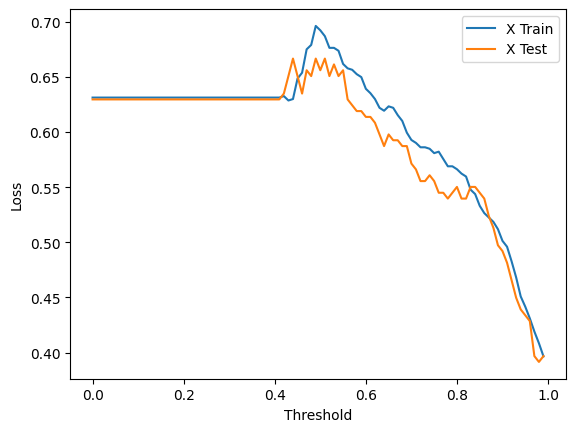

In [ ]:
xAxisData = np.arange(0.0, 1.0, 0.01)
yAxisData = [np.sum(yTrain==(regression.predict(xTrain)>thresh)) / len(yTrain) for thresh in xAxisData]

plt.plot(xAxisData, yAxisData, label='X Train')

xAxisData = np.arange(0.0, 1.0, 0.01)
yAxisData = [np.sum(yTest==(regression.predict(xTest)>thresh)) / len(yTest) for thresh in xAxisData]

plt.plot(xAxisData, yAxisData, label='X Test')

plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = regression.predict(testDatasetX) > 0.5
newIds = ids.reshape((ids.shape[0], 1))
newPredictions = predictions.reshape((predictions.shape[0], 1))
newPredictions = newPredictions.astype(float)
newPredictions.shape, newIds.shape

((397, 1), (397, 1))

In [ ]:
testDatasetResults = pd.DataFrame(np.hstack((newIds, newPredictions)), columns=['id', 'TARGET_5Yrs'])
testDatasetResults

,id,TARGET_5Yrs
0,1,1.0
1,2,1.0
2,5,1.0
3,8,0.0
4,12,1.0
...,...,...
392,1325,1.0
393,1332,1.0
394,1333,1.0
395,1334,1.0


In [ ]:
testDatasetResults.to_csv('predictions.csv', index=False)